In [23]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)

import catboost
from catboost import *
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve


import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# other things: 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, recall_score, f1_score, confusion_matrix, precision_score

import shap 

!jupyter nbextension enable --py widgetsnbextension


Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### all features here: morphometrical and climate  

In [2]:
# in this notebook varya is trying to buld a "best-working" catboost classifier for the DF and FF catchments 
# then "deconstrust" that model for the shap values to see how different features affect the result of the model 
# PD? 


# 1. read data and lable cat features 
# 2. split to train and test 
# 3. find the right hyperparameters (grid search)
# 4. choose the "best model" - save the parameters 
# 5. 



# https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

### 1. read the data, defince X and y, defince categorical features for y 

In [3]:
# read the data: 

path = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/all_points_so_far/ml_model/data_current/'
df = pd.read_csv(path + '09082022dfclim_permafrost.csv', sep = ',', index_col = 0)

df = df[df.target.isin([1,0])]
df = df.drop(['DN', 'Name', 'mean_daylymonsoon_tp_x', 'region_name'], axis = 1)


In [4]:
y = df.target
X = df.drop(columns=['target'])


# # what values are categorical: 
# # region, glacier, avgtemp_belowzero, cont_permafrost, any_permafrost, cont_permafrost_frac50
X['glacier'] = X['glacier'].astype('category') # n 21
X['region'] = X['region'].astype('category') # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype('category') # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype('category') # n 51
X['any_permafrost'] = X['any_permafrost'].astype('category') # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype('category') # n 54

# cat_features = list([12, 21, 34, 50, 51, 53])
cat_features = list(['glacier', 'region', 'avgtemp_belowzero', 'cont_permafrost', 'any_permafrost', 'cont_permafrost_frac50'])

In [5]:
# X.dtypes
# Just change the categorical variables to the string by .astype(str)
# and when you check the data types by using .dtypes you will see them as "objects"
# then pass the cat_features as a list of indices. That would work fine.

# Don't change the data type to the category by .astype('category')


X['glacier'] = X['glacier'].astype(str) # n 21
X['region'] = X['region'].astype(str) # n 12
X['avgtemp_belowzero'] = X['avgtemp_belowzero'].astype(str) # n 34
X['cont_permafrost'] = X['cont_permafrost'].astype(str) # n 51
X['any_permafrost'] = X['any_permafrost'].astype(str) # n 52
X['cont_permafrost_frac50'] = X['cont_permafrost_frac50'].astype(str) # n 54

cat_features = list([12, 21, 34, 50, 51, 53])
# cat_features = list(['glacier', 'region', 'avgtemp_belowzero', 'cont_permafrost', 'any_permafrost', 'cont_permafrost_frac50'])

In [6]:
# data split:

df['target'].value_counts()

1    539
0    173
Name: target, dtype: int64

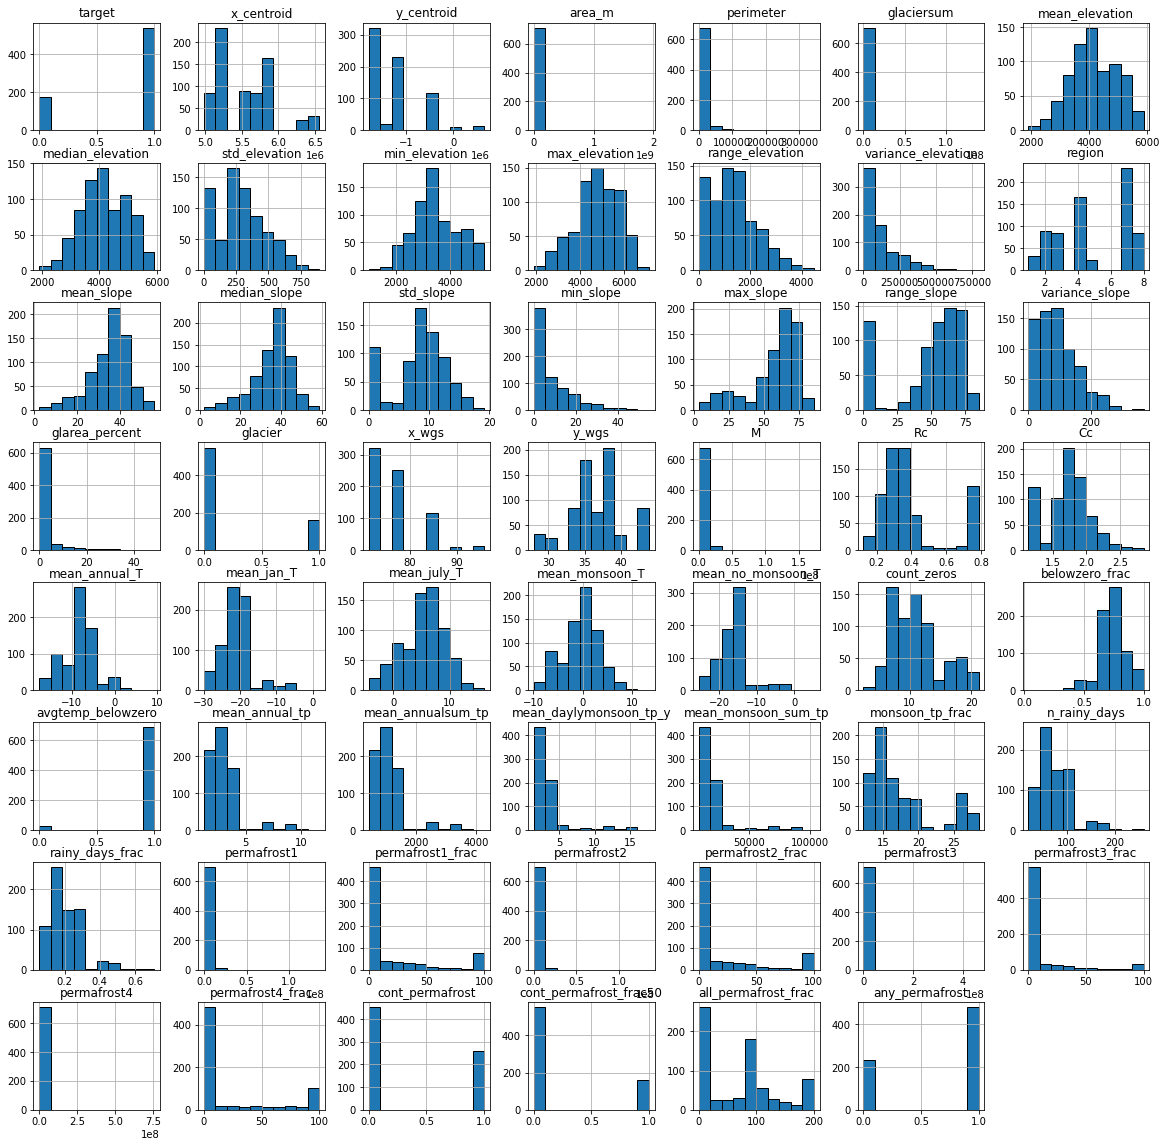

In [7]:
df.hist(edgecolor = "black" , figsize = (20 , 20));


### 2. classifier data prep: split to train and test, convert to pool data class 

In [8]:
# train test 

seed = 42
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [9]:
# X_train.dtypes

In [24]:
# pool

train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                 )

test_pool = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features,
                 )

data_pool = Pool(X, y, cat_features = cat_features)

### 3. catboost classifier - build the model and identify the hyperparameters that are needed 

In [11]:
# default parameters:

params = {
    'loss_function': 'CrossEntropy',
    'iterations': 500,
    'learning_rate': 0.03,
    # 'eval_metric': metrics.Accuracy(),#, metrics.AUC()],
    # 'eval_metric': metrics.AUC(),
    'custom_metric' : ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false'],
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}

### simple model (default-ish) 

In [12]:

# ------ model ------
model = CatBoostClassifier(**params)
model.fit(train_pool, 
          eval_set=test_pool, 
          plot = True)

print('simple model validation Accuracy: {:.4}'.format(
    accuracy_score(y_test, model.predict(X_test))
))


print('best model get best iteration: \n', model.get_best_iteration())

print('\n simple model get best score: \n', model.get_best_score())



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

simple model validation Accuracy: 0.9019
best model get best iteration: 
 121

 simple model get best score: 
 {'learn': {'Accuracy': 1.0, 'Logloss': 0.02641871631810887, 'CrossEntropy': 0.02641871631810887, 'AUC': 1.0}, 'validation': {'Accuracy': 0.9112149532710281, 'Logloss': 0.29971753525515543, 'CrossEntropy': 0.29971753525515543, 'AUC': 0.9162757127390834}}


In [ ]:
(fpr, tpr, thresholds) = get_roc_curve(model, train_pool, plot=True)
# print(fpr)
# print(tpr)
# print(thresholds)

In [13]:

# ------ best model ------

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})

best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, 
               eval_set=test_pool, 
               plot = True)



print('Best model validation Accuracy: {:.4}'.format(
    accuracy_score(y_test, best_model.predict(X_test))
))

print('')
print('parameters for the "best model: \n', best_model.get_params())

print(' ')
print('best model get best iteration: \n', best_model.get_best_iteration())

print(' ')
print('best model get best score: \n', best_model.get_best_score())




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best model validation Accuracy: 0.8925

parameters for the "best model: 
 {'iterations': 500, 'learning_rate': 0.03, 'loss_function': 'CrossEntropy', 'random_seed': 42, 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['Logloss', 'Accuracy', 'AUC:hints=skip_train~false']}
 
best model get best iteration: 
 121
 
best model get best score: 
 {'learn': {'Accuracy': 1.0, 'Logloss': 0.02641871631810887, 'CrossEntropy': 0.02641871631810887, 'AUC': 1.0}, 'validation': {'Accuracy': 0.9112149532710281, 'Logloss': 0.29971753525515543, 'CrossEntropy': 0.29971753525515543, 'AUC': 0.9162757127390834}}


Cannot restore border parameter, falling to default border = 0.5


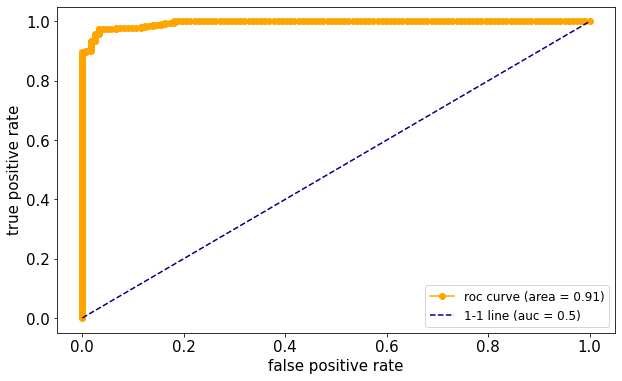

In [14]:

fpr, tpr, thresholds = get_roc_curve(best_model, train_pool, plot=False)

roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[: , 1])

# print(thresholds)
## calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_test, probs)
# auc = roc_auc_score(y_test, probs)


fig, ax = plt.subplots(figsize = (10,6))
plt.plot(fpr, tpr, color = 'orange', marker='o', label = 'roc curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label = '1-1 line (auc = 0.5)')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate',fontsize=15)
plt.legend(fontsize=12)

In [16]:
print('catboost best model Area Under ROC curve:', round(roc, 3))


catboost best model Area Under ROC curve: 0.908


### model done - next - predictions 

In [17]:
probs = best_model.predict_proba(X)


## predictions done! next: what does that mean 

In [18]:
feature_import = best_model.get_feature_importance(prettified=True)
feature_import.head()

,Feature Id,Importances
0,area_m,12.853109
1,M,10.876643
2,mean_slope,6.450088
3,median_slope,6.048886
4,perimeter,5.540267


Text(0.5, 1.0, 'CatBoost features importance:')

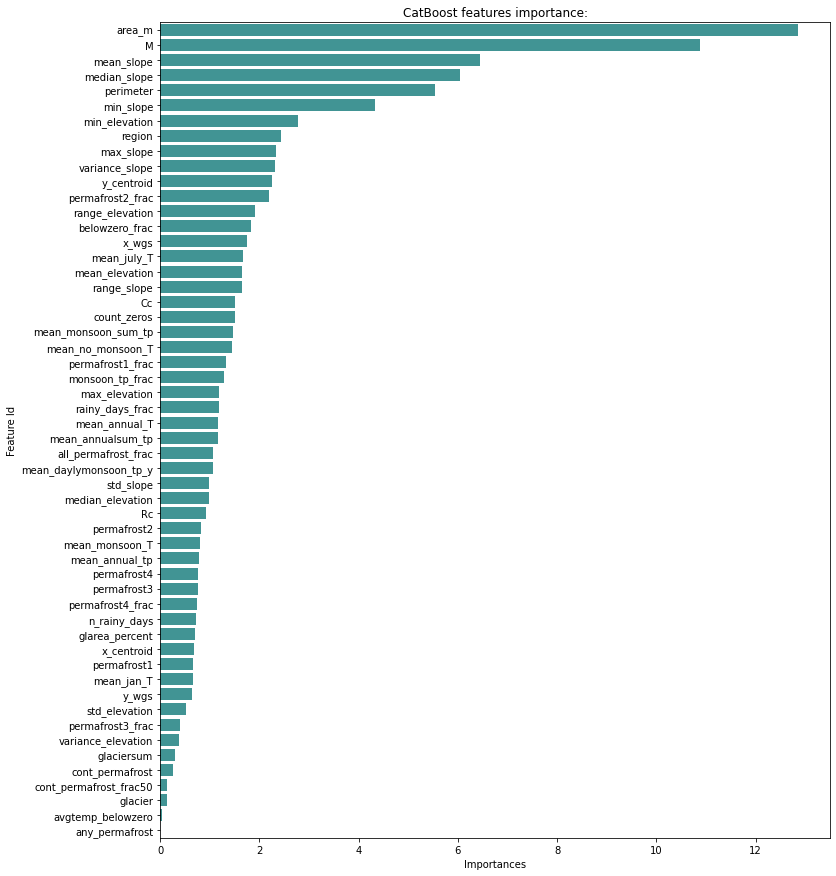

In [21]:
plt.figure(figsize=(12, 15))
sns.barplot(x="Importances", y="Feature Id", data=feature_import, color='darkcyan', alpha = 0.8)
plt.title('CatBoost features importance:')

In [43]:
shap_values_X = best_model.get_feature_importance(data_pool, type='ShapValues')
shap_values_test = best_model.get_feature_importance(test_pool, type='ShapValues')

shap_values_test = shap_values_test[:,:-1]

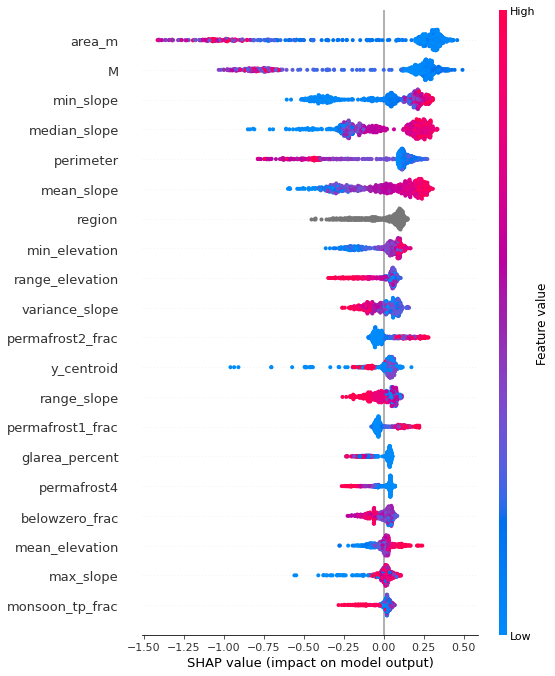

In [44]:
explainer = shap.TreeExplainer(best_model)

shap_valuesX = explainer.shap_values(X)
shap.summary_plot(shap_valuesX, X)

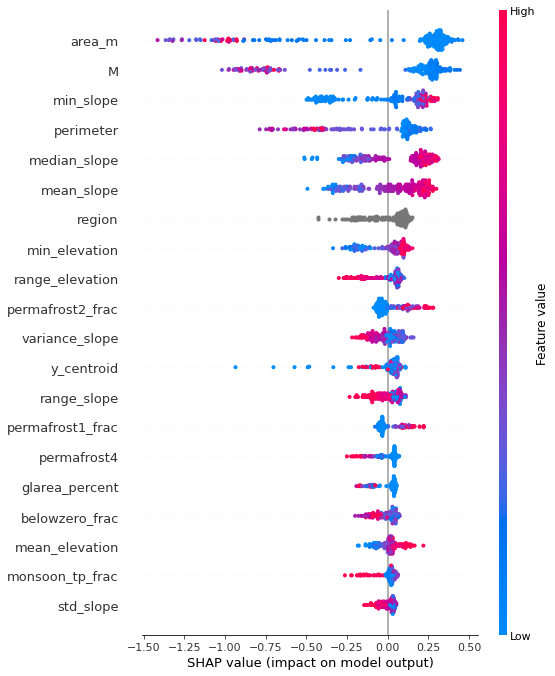

In [45]:
shap_valuesTE = explainer.shap_values(X_test)
shap.summary_plot(shap_valuesTE, X_test)

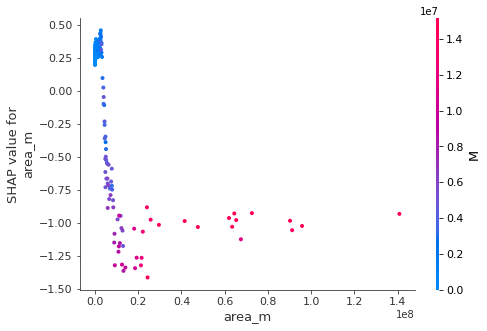

In [51]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('area_m', shap_values_test, X_test)

In [ ]:
# hyperparams matter but not that much for this toy-model exersise 

# ## hyperparameters tuning: 

# hyperparams = {'depth'         :[2,4,6,8,10],
#                'learning_rate' :[0.01,0.03,0.05,0.07,0.1],
#                'l2_leaf_reg'  : [0, 2, 1],
#                'iterations' : [28]
#                }


# # cv: None — Use the default three-fold cross-validation.
# # 
# Grid_CBC = GridSearchCV(estimator=best_model, param_grid = hyperparams, cv = 2, n_jobs=-1)

# # Grid_CBC.fit(X_train, y_train)

# Grid_CBC.fit(
#     X_train, y_train,
#     cat_features=cat_features,
#     eval_set=(X_test, y_test), 
# #     logging_level='Verbose',  # you can uncomment this for text output
#     plot=True
# )


# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)|